In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import sys
import requests
from pyspark.sql import SparkSession, functions as F
#parameter for master can be changed depending on the environment

In [2]:
spark = SparkSession.builder.master("local").appName("Exercise1").getOrCreate()

In [3]:
url = "https://raw.githubusercontent.com/Xiru1024/BigDataExercise/refs/heads/main/exampleData.csv"
local_path = "/home/jovyan/BigDataExercise/exercise1/example.csv"
with open(local_path, "wb") as f:
    f.write(requests.get(url).content)

17430727

In [4]:
df = spark.read.csv(local_path, header=True, inferSchema=True) 
df.show(vertical=True)

-RECORD 0--------------------------------
 _c0                 | 14                
 dateTime            | 01-jan-1990 00:00 
 indicator_rain      | 0                 
 precipitation       | 0.3               
 indicator_temp      | 0                 
 air_temperature     | 9.1               
 indicator_wetb      | 0                 
 wetb                | 9.0               
 dewpt               | 8.9               
 vappr               | 11.4              
 relative_humidity   | 99                
 msl                 | 1006.7            
 indicator_wdsp      | 2                 
 wind_speed          | 7                 
 indicator_wddir     | 2                 
 wind_from_direction | 190               
-RECORD 1--------------------------------
 _c0                 | 15                
 dateTime            | 01-jan-1990 01:00 
 indicator_rain      | 0                 
 precipitation       | 0.2               
 indicator_temp      | 0                 
 air_temperature     | 8.2        

In [5]:
df.printSchema() 

root
 |-- _c0: integer (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- indicator_rain: integer (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- indicator_temp: integer (nullable = true)
 |-- air_temperature: string (nullable = true)
 |-- indicator_wetb: integer (nullable = true)
 |-- wetb: string (nullable = true)
 |-- dewpt: string (nullable = true)
 |-- vappr: string (nullable = true)
 |-- relative_humidity: string (nullable = true)
 |-- msl: string (nullable = true)
 |-- indicator_wdsp: integer (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- indicator_wddir: integer (nullable = true)
 |-- wind_from_direction: integer (nullable = true)



In [6]:
writePath = "/home/jovyan/BigDataExercise/exercise1/written_example.csv"
df.write.mode("overwrite").csv(writePath, header=True) 

In [7]:
df_id = df.withColumn("id", F.monotonically_increasing_id())
df = df_id.select("id", *df.columns)

In [8]:
df.selectExpr("wetb * 5 as newColumn", "round(air_temperature) as roundedTemper").show()

+---------+-------------+
|newColumn|roundedTemper|
+---------+-------------+
|     45.0|          9.0|
|     37.0|          8.0|
|     37.0|          8.0|
|     37.5|          8.0|
|     36.5|          8.0|
|     35.0|          8.0|
|     34.0|          7.0|
|     30.0|          7.0|
|     31.0|          7.0|
|     30.5|          7.0|
|     30.5|          8.0|
|     33.0|          8.0|
|     39.0|         10.0|
|     35.0|          9.0|
|     40.0|         10.0|
|     37.5|          9.0|
|     35.5|          9.0|
|     33.0|          8.0|
|     35.5|          9.0|
|     34.0|          8.0|
+---------+-------------+
only showing top 20 rows



In [9]:
df0 = df.selectExpr("wetb as wetbulb")
df.withColumnRenamed("wetb", "rename_wetb").show()

+---+---+-----------------+--------------+-------------+--------------+---------------+--------------+-----------+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| id|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|rename_wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+---+-----------------+--------------+-------------+--------------+---------------+--------------+-----------+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|  0| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0|        9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
|  1| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0|        7.4|  6.4|  9.7|               89|

In [10]:
df1 = df.selectExpr("cast(air_temperature as float) air_temperature") 
df1.dtypes

[('air_temperature', 'float')]

In [11]:
df.createOrReplaceTempView("example")
pr = spark.sql("Select  air_temperature, count(air_temperature) AS total_freq, count(distinct air_temperature) AS unique_air_temp,count(distinct wetb) AS unique_wetb FROM example GROUP BY air_temperature")
pr.show()

+---------------+----------+---------------+-----------+
|air_temperature|total_freq|unique_air_temp|unique_wetb|
+---------------+----------+---------------+-----------+
|           10.7|      1926|              1|         48|
|            8.5|      1761|              1|         44|
|           20.5|        70|              1|         33|
|           -1.2|        24|              1|         12|
|            1.0|        93|              1|         20|
|            8.2|      1560|              1|         45|
|            2.6|       342|              1|         29|
|            7.3|      1230|              1|         43|
|            3.1|       464|              1|         31|
|           16.6|       994|              1|         51|
|           12.8|      1623|              1|         48|
|           14.2|      1655|              1|         51|
|           17.1|       713|              1|         56|
|           -2.4|        11|              1|          6|
|            8.3|      1639|   

In this way no data frame is required, you can create sql table directly from CSV file instead of from data frame

In [12]:
spark.sql(f"""
    CREATE OR REPLACE TEMPORARY VIEW example
    USING csv
    OPTIONS (
        path '{local_path}',
        header 'true',
        inferSchema 'true'
    )
""")
spark.sql("SELECT * FROM example LIMIT 5").show()


DataFrame[]

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0| 9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0| 7.4|  6.4|  9.7|               89|1006.7|             2|         5|              2|      

In [13]:
import pandas as pd   
import matplotlib.pyplot as plt

<Axes: xlabel='precipitation', ylabel='air_temperature'>

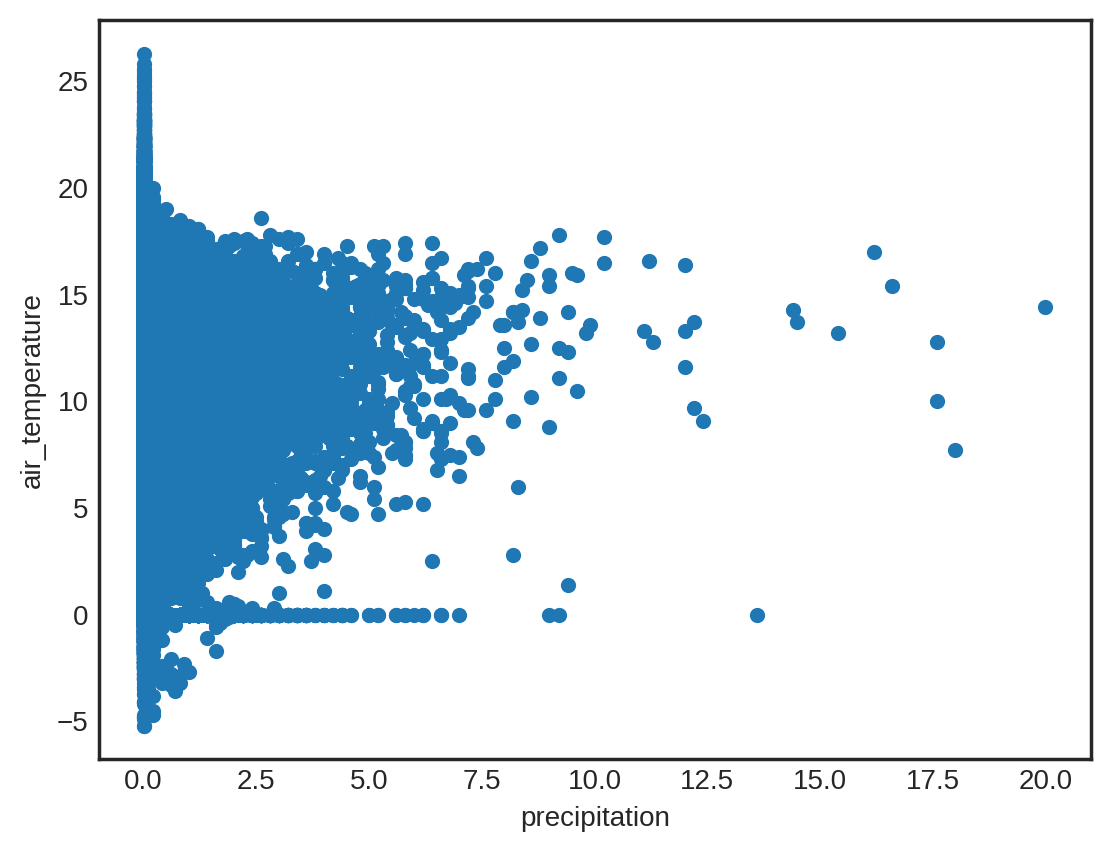

In [14]:
plt.style.use('seaborn-v0_8-white')
dfpanda = df.toPandas()
params = {'legend.fontsize': 'large', 'figure.figsize': (15, 9), 'axes.labelsize': 'x-large', 'axes.titlesize':'x-large', 'xtick.labelsize':'large', 'ytick.labelsize':'large'}
dfpanda['precipitation'] = pd.to_numeric(dfpanda.precipitation,errors='coerce') 
dfpanda['air_temperature'] = pd.to_numeric(dfpanda.air_temperature,errors='coerce') 
dfpanda.plot(kind='scatter',x='precipitation',y='air_temperature') 